<a href="https://colab.research.google.com/github/AntonioWh1te/The-Journey/blob/main/Phase_5_1_Neural_Network_LSTM_Practice_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter your FMP API Key Here: ··········

=== NVDA Feature Analysis and Dynamic Trade Recommendation ===

Today is: 2025-03-04
Macro-Economic Indicators (as of today):
 - Interest Rate: 2.5%
 - Inflation Rate: 2.0%
 - GDP Growth: 3.0%

Feature: Partial Hedging Signal
 - NVDA appears to be in a sideways, accumulation phase based on the 20-day MA slope.

Feature: Performance Attribution
 - Overall return since 2015-01-01: 26584.55%

Feature: Laplace’s Law Probability
 - Based on the last 100 days, the probability of an up day is estimated at 54.90%

Feature: Price Trend
 - Current closing price: $134.29
 - 20-day Moving Average: $137.15

Feature: ATR (Volatility)
 - ATR (14-day): $5.18 (indicates the average price movement range)

Feature: MACD for Momentum
 - Current MACD: -0.7634 (Signal line: -0.9565)
   This suggests bullish momentum; the MACD line is above the signal line.

Feature: Volume Analysis
 - 30-day Average Volume: 212885264 shares (higher volume can confirm trends)

Feature

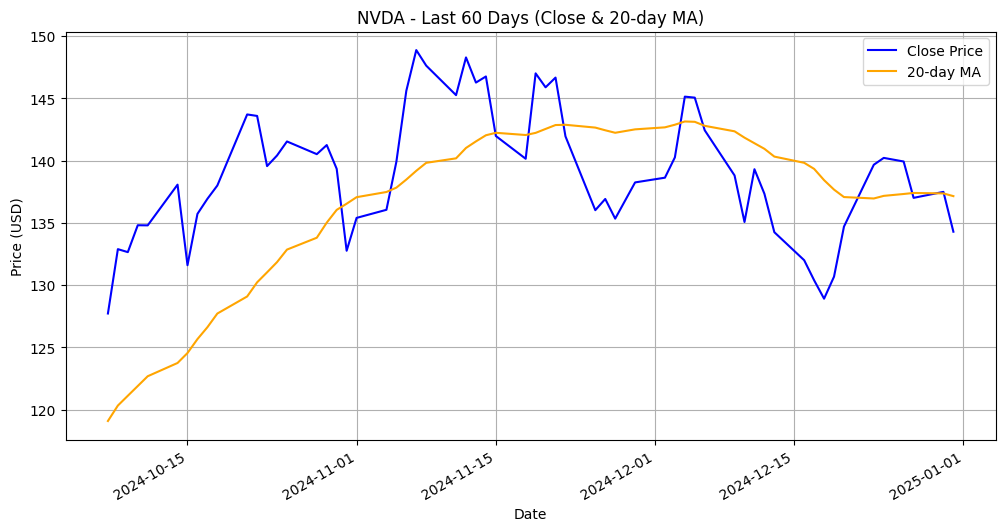


=== NVDA Feature Table ===

╒═══════════════════════════╤════════════════════════════╕
│ Feature                   │ Value                      │
╞═══════════════════════════╪════════════════════════════╡
│ Partial Hedging Signal    │ Sideways                   │
├───────────────────────────┼────────────────────────────┤
│ Performance Attribution   │ 26584.55% since 2015-01-01 │
├───────────────────────────┼────────────────────────────┤
│ Laplace’s Law Probability │ 54.90% (chance of up day)  │
├───────────────────────────┼────────────────────────────┤
│ Current Close / 20-day MA │ $134.29 / $137.15          │
├───────────────────────────┼────────────────────────────┤
│ ATR (14-day)              │ $5.18 (avg daily range)    │
├───────────────────────────┼────────────────────────────┤
│ MACD / Signal             │ -0.7634 / -0.9565          │
├───────────────────────────┼────────────────────────────┤
│ Volume (30-day Avg)       │ 212885264                  │
├──────────────────────────

In [ ]:
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import requests
import datetime

##############################################
# STEP 1: DATA FETCHING FUNCTIONS
##############################################

def get_historical_data(symbol, start, end, apikey):
    """
    Fetch historical price data from FMP for a given symbol and date range.
    Returns a DataFrame with columns: open, high, low, close, volume.
    """
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start}&to={end}&apikey={apikey}"
    response = requests.get(url)
    data = response.json()

    if 'historical' in data:
        df = pd.DataFrame(data['historical'])
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        return df
    else:
        print(f"Error fetching data for {symbol}: {data}")
        return None

def get_macro_data(apikey):
    """
    Retrieve macroeconomic indicators for the current day.
    This function attempts to fetch real data from FMP.
    If unavailable, it returns simulated values.
    """
    # For demonstration, we'll attempt to use a dummy endpoint.
    # In practice, replace this with a proper API call.
    url = f"https://financialmodelingprep.com/api/v3/economic?apikey={apikey}"
    try:
        response = requests.get(url)
        data = response.json()
        # Assume data is a list of indicators and we pick the latest ones.
        if isinstance(data, list) and len(data) > 0:
            # Extract some sample indicators.
            # (The exact fields depend on the API; here we simulate.)
            interest_rate = float(data[0].get("interestRate", 2.5))
            inflation_rate = float(data[0].get("inflationRate", 2.0))
            gdp_growth = float(data[0].get("gdpGrowth", 3.0))
        else:
            # Simulated values if API doesn't return data.
            interest_rate, inflation_rate, gdp_growth = 2.5, 2.0, 3.0
    except Exception as e:
        # If the call fails, use dummy values.
        interest_rate, inflation_rate, gdp_growth = 2.5, 2.0, 3.0

    # Get today's date
    today = datetime.date.today()
    return {
        "date": today,
        "interest_rate": interest_rate,
        "inflation_rate": inflation_rate,
        "gdp_growth": gdp_growth
    }

##############################################
# STEP 2: TECHNICAL INDICATOR FUNCTIONS
##############################################

def moving_average(df, window=20):
    """Calculate the simple moving average of the 'close' column."""
    return df['close'].rolling(window=window).mean()

def ATR(df, window=14):
    """Calculate the Average True Range (ATR) for volatility."""
    df['prev_close'] = df['close'].shift(1)
    df['tr1'] = df['high'] - df['low']
    df['tr2'] = (df['high'] - df['prev_close']).abs()
    df['tr3'] = (df['low'] - df['prev_close']).abs()
    df['true_range'] = df[['tr1','tr2','tr3']].max(axis=1)
    atr = df['true_range'].rolling(window=window).mean()
    df.drop(['prev_close','tr1','tr2','tr3','true_range'], axis=1, inplace=True)
    return atr

def MACD(df):
    """Calculate the MACD and signal line."""
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    macd_line = ema12 - ema26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    return macd_line, signal_line

def bollinger_band_width(df, window=20, num_std=2):
    """Calculate the Bollinger Band Width as a percentage."""
    ma = df['close'].rolling(window=window).mean()
    std = df['close'].rolling(window=window).std()
    upper_band = ma + num_std * std
    lower_band = ma - num_std * std
    bb_width = (upper_band - lower_band) / ma
    return bb_width

def price_rate_of_change(df, period=10):
    """Calculate the Price Rate of Change (ROC) over a given period."""
    roc = ((df['close'] - df['close'].shift(period)) / df['close'].shift(period)) * 100
    return roc

def laplace_probability(win_count, total):
    """Calculate probability using Laplace's law: (w+1)/(n+2)."""
    return (win_count + 1) / (total + 2)

##############################################
# STEP 3: MAIN SCRIPT FOR NVDA ANALYSIS
##############################################

# User inputs
apikey = getpass.getpass("Enter your FMP API Key Here: ")
start = '2015-01-01'
end = '2025-01-01'
symbol = 'NVDA'

# Fetch NVDA historical data
nvda_df = get_historical_data(symbol, start, end, apikey)
if nvda_df is None:
    print("Failed to fetch NVDA data.")
    exit()

# Retrieve macroeconomic indicators for today
macro_data = get_macro_data(apikey)

# ------------------------------
# Feature Calculations:
# ------------------------------

# 1. Partial Hedging Signal:
#    We'll check if the market is sideways by examining the slope of a 20-day moving average.
ma20 = moving_average(nvda_df, window=20)
ma_slope = ma20.diff().rolling(window=5).mean()  # Average change over 5 days
sideways = ma_slope.abs().iloc[-1] < 0.1  # Threshold for sideways movement

# Dynamic investment:
# Base long investment is $100. If ATR (relative move) is high, invest more.
atr_value = ATR(nvda_df.copy(), window=14).iloc[-1]
current_close = nvda_df['close'].iloc[-1]
relative_move = atr_value / current_close  # e.g., 0.05 means 5%
# Increase investment if relative_move is above 5%
if relative_move > 0.05:
    multiplier = 1 + (relative_move - 0.05) * 10  # simple scaling factor
else:
    multiplier = 1
recommended_long = 100 * multiplier
recommended_short = 0.25 * recommended_long if sideways else 0  # Hedge only in sideways markets

# 2. Performance Attribution:
overall_return = (nvda_df['close'].iloc[-1] - nvda_df['close'].iloc[0]) / nvda_df['close'].iloc[0] * 100

# 3. Laplace’s Law Probability:
recent_close = nvda_df['close'].iloc[-101:]  # Last 100 days + initial day
win_days = (recent_close.diff() > 0).sum()
laplace_prob = laplace_probability(win_days, len(recent_close) - 1)

# 4. Closing Price and Moving Average:
current_ma20 = ma20.iloc[-1]

# 5. ATR for Volatility: (already computed as atr_value)

# 6. MACD for Momentum:
macd_line, signal_line = MACD(nvda_df)
current_macd = macd_line.iloc[-1]
current_signal = signal_line.iloc[-1]

# 7. Volume Analysis:
avg_volume = nvda_df['volume'].rolling(window=30).mean().iloc[-1] if 'volume' in nvda_df.columns else None

# 8. Macro-Economic Indicators (from get_macro_data):
interest_rate = macro_data["interest_rate"]
inflation_rate = macro_data["inflation_rate"]
gdp_growth = macro_data["gdp_growth"]

# 9. Bollinger Band Width:
bb_width = bollinger_band_width(nvda_df, window=20).iloc[-1]

# 10. Price Rate of Change (ROC):
roc_value = price_rate_of_change(nvda_df, period=10).iloc[-1]

##############################################
# STEP 4: PLAIN ENGLISH OUTPUT & DYNAMIC RECOMMENDATION
##############################################

print("\n=== NVDA Feature Analysis and Dynamic Trade Recommendation ===\n")

# Today's Date and Macro Data
print(f"Today is: {macro_data['date']}")
print(f"Macro-Economic Indicators (as of today):")
print(f" - Interest Rate: {interest_rate}%")
print(f" - Inflation Rate: {inflation_rate}%")
print(f" - GDP Growth: {gdp_growth}%\n")

# Feature 1: Partial Hedging Signal
if sideways:
    print("Feature: Partial Hedging Signal")
    print(" - NVDA appears to be in a sideways, accumulation phase based on the 20-day MA slope.")
else:
    print("Feature: Trend Signal")
    print(" - NVDA is trending strongly rather than trading sideways.")

# Feature 2: Performance Attribution
print(f"\nFeature: Performance Attribution")
print(f" - Overall return since {start}: {overall_return:.2f}%")

# Feature 3: Laplace’s Probability
print(f"\nFeature: Laplace’s Law Probability")
print(f" - Based on the last 100 days, the probability of an up day is estimated at {laplace_prob*100:.2f}%")

# Feature 4: Closing Price and Moving Average
print(f"\nFeature: Price Trend")
print(f" - Current closing price: ${current_close:.2f}")
print(f" - 20-day Moving Average: ${current_ma20:.2f}")

# Feature 5: ATR for Volatility
print(f"\nFeature: ATR (Volatility)")
print(f" - ATR (14-day): ${atr_value:.2f} (indicates the average price movement range)")

# Feature 6: MACD for Momentum
print(f"\nFeature: MACD for Momentum")
print(f" - Current MACD: {current_macd:.4f} (Signal line: {current_signal:.4f})")
if current_macd > current_signal:
    print("   This suggests bullish momentum; the MACD line is above the signal line.")
else:
    print("   This suggests bearish momentum; the MACD line is below the signal line.")

# Feature 7: Volume Analysis
if avg_volume is not None:
    print(f"\nFeature: Volume Analysis")
    print(f" - 30-day Average Volume: {avg_volume:.0f} shares (higher volume can confirm trends)")
else:
    print("Volume data is not available.")

# Feature 8: Macro-Economic Indicators (already printed above)

# Feature 9: Bollinger Band Width
print(f"\nFeature: Bollinger Band Width")
print(f" - Current Bollinger Band Width: {bb_width*100:.2f}% (a wider band indicates higher volatility)")

# Feature 10: Price Rate of Change (ROC)
print(f"\nFeature: Price Rate of Change (ROC)")
print(f" - 10-day ROC: {roc_value:.2f}% (a positive ROC indicates upward momentum)")

# Dynamic Trade Recommendation:
print("\n--- Dynamic Trade Recommendation ---")
print(f"Based on today's analysis:")
if sideways:
    print(" - NVDA appears to be in a sideways (accumulation) range.")
else:
    print(" - NVDA shows a clear trend.")

# Adjust the investment size based on relative volatility:
print(f" - The ATR relative to the current price is {relative_move*100:.2f}%.")
if relative_move > 0.05:
    print("   This higher volatility suggests a larger price movement is possible.")
else:
    print("   Volatility is moderate; expect smaller moves.")

print(f"\nCalculated Investment Recommendations:")
print(f" - Recommended Long Position: ${recommended_long:.2f}")
if recommended_short > 0:
    print(f" - Recommended Short Offset: ${recommended_short:.2f} (to hedge risk in sideways markets)")
else:
    print(" - No short offset recommended in a strong trending market.")

# Estimate potential profit/loss (simplified based on ATR):
predicted_move = atr_value  # estimated move in dollars
potential_profit = recommended_long * (predicted_move / current_close)
potential_loss = recommended_short * (predicted_move / current_close) if recommended_short > 0 else 0

print("\nBased on historical volatility (ATR):")
print(f" - If NVDA moves by approximately ${predicted_move:.2f} in the next period:")
print(f"   * Your long position could yield a profit of approximately ${potential_profit:.2f}.")
if recommended_short > 0:
    print(f"   * Your short hedge could mitigate a potential loss of around ${potential_loss:.2f}.")

!pip install tabulate
##############################################
# STEP 5: "Sexier" Output: Plot + Table
##############################################
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from tabulate import tabulate

# 1. Quick Chart of NVDA’s Last 60 Days with 20-day MA
days_to_plot = 60  # Change as desired
recent_data = nvda_df.tail(days_to_plot)
recent_ma20 = ma20.tail(days_to_plot)

plt.figure(figsize=(12,6))
plt.plot(recent_data.index, recent_data['close'], label="Close Price", color='blue')
plt.plot(recent_ma20.index, recent_ma20, label="20-day MA", color='orange')
plt.title(f"NVDA - Last {days_to_plot} Days (Close & 20-day MA)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
# Format x-axis dates for readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Auto-rotate date labels
plt.show()

# 2. Tabulated Feature Summary
#    We'll show each feature and its latest value in a neat table.

# If your script already computed these variables, they should be in scope:
# sideways, overall_return, laplace_prob, current_close, current_ma20,
# atr_value, current_macd, current_signal, avg_volume, bb_width,
# roc_value, recommended_long, recommended_short

feature_table = [
    ["Partial Hedging Signal", "Sideways" if sideways else "Trending"],
    ["Performance Attribution", f"{overall_return:.2f}% since {start}"],
    ["Laplace’s Law Probability", f"{laplace_prob*100:.2f}% (chance of up day)"],
    ["Current Close / 20-day MA", f"${current_close:.2f} / ${current_ma20:.2f}"],
    ["ATR (14-day)", f"${atr_value:.2f} (avg daily range)"],
    ["MACD / Signal", f"{current_macd:.4f} / {current_signal:.4f}"],
    ["Volume (30-day Avg)",
        f"{avg_volume:.0f}" if avg_volume is not None else "N/A"],
    ["Bollinger Band Width",
        f"{bb_width*100:.2f}% (volatility range)"],
    ["ROC (10-day)",
        f"{roc_value:.2f}% (momentum)"],
    ["Recommended Long",
        f"${recommended_long:.2f}"],
    ["Recommended Short",
        f"${recommended_short:.2f}" if recommended_short > 0 else "None"],
]

print("\n=== NVDA Feature Table ===\n")
print(tabulate(feature_table, headers=["Feature", "Value"], tablefmt="fancy_grid"))
print("\nEnjoy your more stylish output!\n")


Enter your FMP API Key Here: ··········


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 32)              │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,425 (36.82 KB)

 Trainable params: 9,425 (36.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 45.8328 - mae: 5.1180 - val_loss: 308.8614 - val_mae: 16.7803
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 20.7376 - mae: 3.1982 - val_loss: 252.6949 - val_mae: 15.0186
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 17.6271 - mae: 2.7661 - val_loss: 216.6075 - val_mae: 13.7577
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10.3214 - mae: 1.8163 - val_loss: 193.4780 - val_mae: 12.8886
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.5157 - mae: 1.5123 - val_loss: 175.0983 - val_mae: 12.1544
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 7.7260 - mae: 1.5666 - val_loss: 159.1166 - val_mae: 11.4778
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.1216 - mae: 1.3511 - val_loss: 145.6308 - val_mae: 10.8746
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.4548 - mae: 1.2868 - val_loss: 133.3370 - val_mae: 10.2935
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━

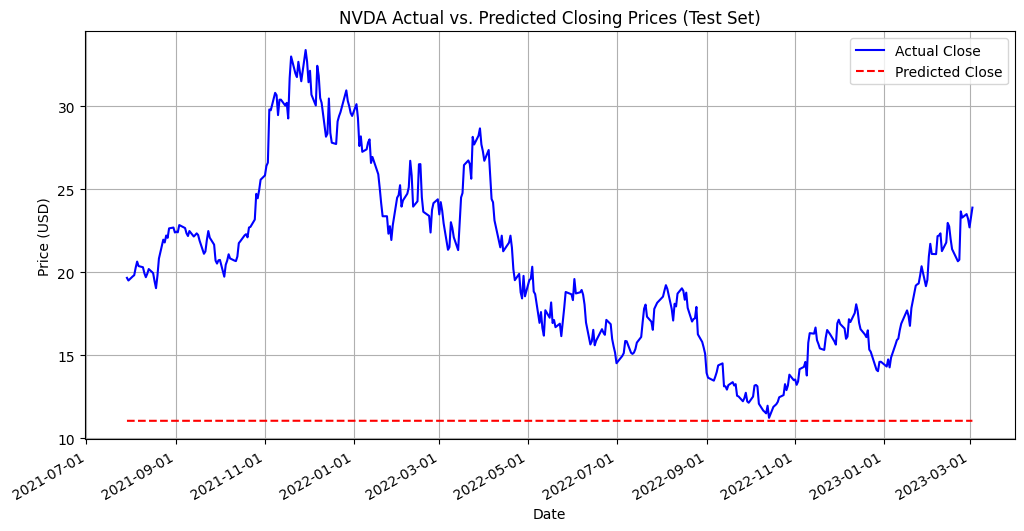


=== NVDA Latest Feature Summary ===

╒══════════════════════╤═════════════════════════╕
│ Feature              │ Value                   │
╞══════════════════════╪═════════════════════════╡
│ Close Price          │ $23.89                  │
├──────────────────────┼─────────────────────────┤
│ 20-day MA            │ $22.30                  │
├──────────────────────┼─────────────────────────┤
│ ATR (14-day)         │ $1.04                   │
├──────────────────────┼─────────────────────────┤
│ MACD                 │ 1.1310 (Signal: 1.1556) │
├──────────────────────┼─────────────────────────┤
│ Bollinger Band Width │ 18.28%                  │
├──────────────────────┼─────────────────────────┤
│ 10-day ROC           │ 8.59%                   │
╘══════════════════════╧═════════════════════════╛

=== Plain English Interpretation ===
Data has been collected from 2015-01-01 to March 3rd, 2023.
Based on NVDA's historical data, the latest closing price is approximately $23.89,
with a 20-day mo

In [ ]:
!pip install tabulate
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate

##############################################
# STEP 1: DATA FETCHING
##############################################
def get_historical_data(symbol, start, end, apikey):
    """
    Fetch historical price data for a given symbol and date range.
    Returns a DataFrame with columns: open, high, low, close, volume, etc.
    """
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start}&to={end}&apikey={apikey}"
    response = requests.get(url)
    data = response.json()
    if 'historical' in data:
        df = pd.DataFrame(data['historical'])
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        return df
    else:
        print(f"Error fetching data for {symbol}: {data}")
        return None

##############################################
# STEP 2: FEATURE ENGINEERING FUNCTIONS
##############################################
def moving_average(df, window=20):
    return df['close'].rolling(window=window).mean()

def ATR(df, window=14):
    temp = df.copy()
    temp['prev_close'] = temp['close'].shift(1)
    temp['tr1'] = temp['high'] - temp['low']
    temp['tr2'] = (temp['high'] - temp['prev_close']).abs()
    temp['tr3'] = (temp['low'] - temp['prev_close']).abs()
    temp['true_range'] = temp[['tr1','tr2','tr3']].max(axis=1)
    atr = temp['true_range'].rolling(window=window).mean()
    return atr

def MACD(df):
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    macd_line = ema12 - ema26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    return macd_line, signal_line

def bollinger_band_width(df, window=20, num_std=2):
    ma = df['close'].rolling(window=window).mean()
    std = df['close'].rolling(window=window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    bb_width = (upper - lower) / ma
    return bb_width

def price_rate_of_change(df, period=10):
    roc = ((df['close'] - df['close'].shift(period)) / df['close'].shift(period)) * 100
    return roc

def compute_features(df):
    """
    Computes numeric features and returns a DataFrame with:
      - close, ATR_14, MACD_line, MACD_signal,
      - Bollinger Band Width (BB_width), 10-day ROC, and 20-day Moving Average (MA_20).
    """
    df_feat = df.copy().dropna()
    df_feat['ATR_14'] = ATR(df_feat, window=14)
    macd_line, macd_signal = MACD(df_feat)
    df_feat['MACD_line'] = macd_line
    df_feat['MACD_signal'] = macd_signal
    df_feat['BB_width'] = bollinger_band_width(df_feat, window=20)
    df_feat['ROC_10'] = price_rate_of_change(df_feat, period=10)
    df_feat['MA_20'] = moving_average(df_feat, window=20)
    df_feat = df_feat.dropna()
    return df_feat

##############################################
# STEP 3: CREATE LSTM DATASET
##############################################
def create_lstm_dataset(feature_df, target_col='close', window=30):
    """
    Creates time-series samples from feature_df.
    Each sample consists of 'window' consecutive days of features.
    The target is the next day's closing price.
    Returns X, y as NumPy arrays and a scaler for the features.
    """
    # Drop any rows with NaNs
    data = feature_df.copy().dropna()
    # Drop non-numeric columns (if any) to ensure scaler works correctly
    X_data = data.drop(columns=[target_col]).select_dtypes(include=[np.number])
    y_data = data[target_col].shift(-1).dropna()
    X_data = X_data.loc[y_data.index]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_data.values)

    X, y = [], []
    for i in range(window, len(X_scaled)):
        X.append(X_scaled[i-window:i, :])
        y.append(y_data.values[i])
    return np.array(X), np.array(y), scaler

##############################################
# STEP 4: MAIN SCRIPT FOR NVDA PREDICTION (Estimate March 4th's Close)
##############################################
apikey = getpass.getpass("Enter your FMP API Key Here: ")
# Data range up to March 3rd, 2023 (latest available closing price)
start = '2015-01-01'
end = '2023-03-03'
symbol = 'NVDA'

nvda_df = get_historical_data(symbol, start, end, apikey)
if nvda_df is None:
    exit("Failed to fetch NVDA data.")

# Compute numeric features
feature_df = compute_features(nvda_df)

# Create LSTM dataset using a 30-day window
X, y, scaler = create_lstm_dataset(feature_df, target_col='close', window=30)

# Train/test split (80% train, 20% test; no shuffling to preserve time order)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build a simple LSTM model
model = Sequential([
    LSTM(32, activation='tanh', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(16, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Predict today's (March 4th) closing price using the most recent 30-day window (ending on March 3rd)
last_window = X[-1:]  # last sample in the dataset
predicted_close = model.predict(last_window)[0][0]

##############################################
# STEP 5: VISUALIZATION & PLAIN ENGLISH INTERPRETATION
##############################################

# Plot actual vs. predicted closing prices for the test set (last 60 days)
y_pred = model.predict(X_test).flatten()
test_dates = feature_df.index[-len(y_test):]  # align dates with test targets

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test, label="Actual Close", color="blue")
plt.plot(test_dates, y_pred, label="Predicted Close", color="red", linestyle="--")
plt.title("NVDA Actual vs. Predicted Closing Prices (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()

# Create a table with the latest feature summary
latest = feature_df.iloc[-1]
feature_table = [
    ["Close Price", f"${latest['close']:.2f}"],
    ["20-day MA", f"${latest['MA_20']:.2f}"],
    ["ATR (14-day)", f"${latest['ATR_14']:.2f}"],
    ["MACD", f"{latest['MACD_line']:.4f} (Signal: {latest['MACD_signal']:.4f})"],
    ["Bollinger Band Width", f"{latest['BB_width']*100:.2f}%"],
    ["10-day ROC", f"{latest['ROC_10']:.2f}%"]
]

print("\n=== NVDA Latest Feature Summary ===\n")
print(tabulate(feature_table, headers=["Feature", "Value"], tablefmt="fancy_grid"))

# Plain English Interpretation
print("\n=== Plain English Interpretation ===")
print(f"Data has been collected from {start} to March 3rd, 2023.")
print(f"Based on NVDA's historical data, the latest closing price is approximately ${latest['close']:.2f},")
print(f"with a 20-day moving average of ${latest['MA_20']:.2f}.")
print(f"The ATR (14-day volatility measure) is ${latest['ATR_14']:.2f}, indicating the average daily price range.")
print(f"The MACD is at {latest['MACD_line']:.4f} (with a signal of {latest['MACD_signal']:.4f}), reflecting current momentum conditions.")
print(f"Bollinger Band Width is {latest['BB_width']*100:.2f}% and the 10-day Price Rate of Change is {latest['ROC_10']:.2f}%.")
print(f"\nUsing the most recent 30 days of data (ending on March 3rd), our LSTM model predicts that NVDA's closing price for today (March 4th) will be approximately ${predicted_close:.2f}.")
print("The graph above compares the model's predictions to the actual closing prices in the test set, providing a visual sense of performance.\n")


Enter your FMP API Key Here: ··········

Last 5 rows:
               open    high     low   close  adjClose     volume  \
date                                                              
2025-02-25  129.98  130.20  124.44  126.63    126.63  271428711   
2025-02-26  129.99  133.73  128.49  131.28    131.28  322553814   
2025-02-27  135.00  135.01  120.01  120.15    120.15  443175846   
2025-02-28  118.02  125.09  116.40  124.92    124.92  389091145   
2025-03-03  123.51  123.70  112.28  114.06    114.06  411381400   

            unadjustedVolume  change  changePercent      vwap  \
date                                                            
2025-02-25         271428711   -3.35       -2.58000  127.8125   
2025-02-26         322553814    1.29        0.99238  130.8725   
2025-02-27         443175846  -14.85      -11.00000  127.5425   
2025-02-28         389091145    6.90        5.85000  121.1075   
2025-03-03         411381400   -9.45       -7.65000  118.3875   

                   

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 32)              │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,553 (37.32 KB)

 Trainable params: 9,553 (37.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 0.5274 - mae: 0.6478 - val_loss: 0.1231 - val_mae: 0.3240
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1216 - mae: 0.2737 - val_loss: 0.0259 - val_mae: 0.1328
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1217 - mae: 0.2924 - val_loss: 0.0265 - val_mae: 0.1341
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0670 - mae: 0.2112 - val_loss: 0.0201 - val_mae: 0.1155
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0510 - mae: 0.1885 - val_loss: 0.0401 - val_mae: 0.1701
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0516 - mae: 0.1803 - val_loss: 0.0212 - val_mae: 0.1221
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0376 - mae: 0.1571 - val_loss: 0.0137 - val_mae: 0.0958
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0380 - mae: 0.1557 - val_loss: 0.0139 - val_mae: 0.0941
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0317 - mae: 0.1429 -

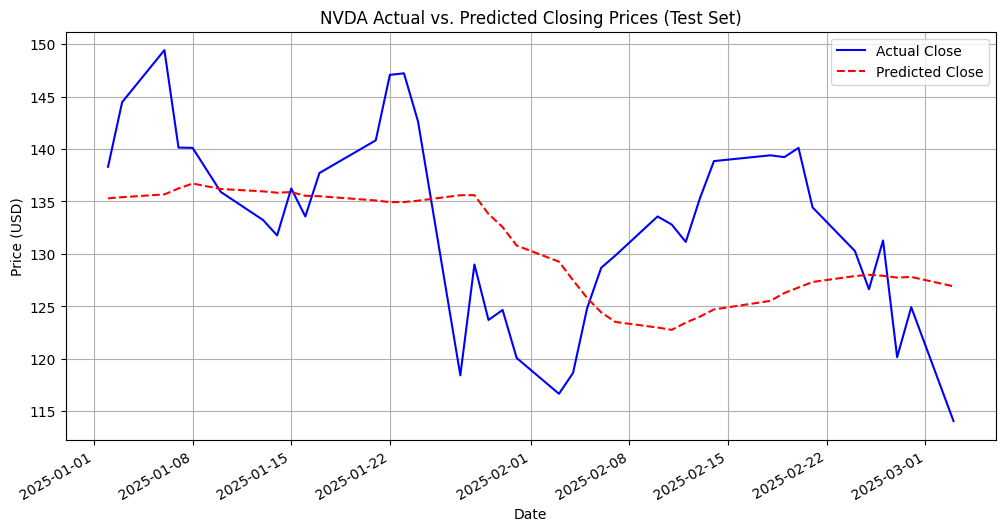


=== NVDA Latest Feature Summary ===

╒═════════════╤═════════╕
│ Feature     │ Value   │
╞═════════════╪═════════╡
│ Close Price │ $114.06 │
├─────────────┼─────────┤
│ MA_20       │ $129.54 │
├─────────────┼─────────┤
│ ATR_14      │ 6.80    │
├─────────────┼─────────┤
│ MACD_line   │ -2.6946 │
├─────────────┼─────────┤
│ MACD_signal │ -1.0304 │
├─────────────┼─────────┤
│ BB_width    │ 23.97%  │
├─────────────┼─────────┤
│ ROC_10      │ -17.85% │
╘═════════════╧═════════╛

=== Plain English Interpretation ===
Data from 2024-03-03 to 2025-03-03, raw daily. We do separate scaling for X (features) and y (target).
We used a 30-day window and trained for 50 epochs to avoid flat predictions.
The predicted next day's close is about $126.91.



In [ ]:
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate

##############################################
# STEP 1: DATA FETCHING (RAW DAILY DATA)
##############################################
def get_historical_data(symbol, start, end, apikey):
    """
    Fetch raw daily price data (unadjusted) for a given symbol and date range
    from Financial Modeling Prep. This includes columns like open, high, low, close, volume.
    """
    url = (
        f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}"
        f"?from={start}&to={end}&apikey={apikey}"
    )
    response = requests.get(url)
    data = response.json()
    if 'historical' in data:
        df = pd.DataFrame(data['historical'])
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        return df
    else:
        print(f"Error fetching data for {symbol}: {data}")
        return None

##############################################
# STEP 2: FEATURE ENGINEERING FUNCTIONS
##############################################
def ATR(df, window=14):
    temp = df.copy()
    temp['prev_close'] = temp['close'].shift(1)
    temp['tr1'] = temp['high'] - temp['low']
    temp['tr2'] = (temp['high'] - temp['prev_close']).abs()
    temp['tr3'] = (temp['low'] - temp['prev_close']).abs()
    temp['true_range'] = temp[['tr1','tr2','tr3']].max(axis=1)
    atr = temp['true_range'].rolling(window=window).mean()
    return atr

def MACD(df):
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    macd_line = ema12 - ema26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    return macd_line, signal_line

def bollinger_band_width(df, window=20, num_std=2):
    ma = df['close'].rolling(window=window).mean()
    std = df['close'].rolling(window=window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    bb_width = (upper - lower) / ma
    return bb_width

def price_rate_of_change(df, period=10):
    roc = ((df['close'] - df['close'].shift(period)) / df['close'].shift(period)) * 100
    return roc

def moving_average(df, window=20):
    return df['close'].rolling(window=window).mean()

def compute_features(df):
    """
    Computes numeric features using raw daily data:
      - ATR (14-day)
      - MACD (macd_line, macd_signal)
      - Bollinger Band Width (BB_width)
      - 10-day ROC (ROC_10)
      - 20-day Moving Average (MA_20)
    """
    df_feat = df.copy().dropna()
    df_feat['ATR_14'] = ATR(df_feat, window=14)
    macd_line, macd_signal = MACD(df_feat)
    df_feat['MACD_line'] = macd_line
    df_feat['MACD_signal'] = macd_signal
    df_feat['BB_width'] = bollinger_band_width(df_feat, window=20)
    df_feat['ROC_10'] = price_rate_of_change(df_feat, period=10)
    df_feat['MA_20'] = moving_average(df_feat, window=20)
    df_feat.dropna(inplace=True)
    return df_feat

##############################################
# STEP 3: BUILD DATASET (SIMPLIFIED APPROACH)
##############################################
def build_dataset(df_feat, target_col='close', window=30):
    """
    1) Create a new column 'target' = next day's close (shift -1).
    2) Drop any row with NaN.
    3) Scale features (X) and target (y) separately.
    4) Create sequences of length 'window' for X, with y being the next day's target.
    """
    data = df_feat.copy()

    # 1) Create 'target' column for next-day close
    data['target'] = data[target_col].shift(-1)

    # 2) Drop final row(s) with NaN
    data.dropna(inplace=True)

    # Separate features vs. target
    X_data = data.drop(columns=['target'])  # includes 'close' but that's okay
    y_data = data['target'].values.reshape(-1, 1)  # shape (N,1)

    # Keep only numeric columns in X_data
    X_data = X_data.select_dtypes(include=[np.number])

    # 3) Scale features (X) and target (y) separately
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_scaled = X_scaler.fit_transform(X_data)
    y_scaled = y_scaler.fit_transform(y_data)

    # 4) Build sequences of length 'window'
    X, y = [], []
    for i in range(window, len(X_scaled)):
        X_seq = X_scaled[i-window:i, :]
        y_val = y_scaled[i]  # scaled target for day i
        X.append(X_seq)
        y.append(y_val)

    return np.array(X), np.array(y), X_scaler, y_scaler

##############################################
# STEP 4: MAIN SCRIPT
##############################################
apikey = getpass.getpass("Enter your FMP API Key Here: ")

# Example date range
start = '2024-03-03'
end   = '2025-03-03'
symbol = 'EPR'

EPR_df = get_historical_data(symbol, start, end, apikey)
if EPR_df is None or EPR_df.empty:
    exit(f"No data found for {symbol} from {start} to {end}.")

print("\nLast 5 rows:\n", EPR_df.tail(5))

# Compute features
feature_df = compute_features(EPR_df)

# Build dataset
window_size = 30
X, y, X_scaler, y_scaler = build_dataset(feature_df, target_col='close', window=window_size)
if len(X) < 1:
    exit("Not enough data after building dataset. Increase your date range or reduce window size.")

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build model
model = Sequential([
    LSTM(32, activation='tanh', return_sequences=True, input_shape=(window_size, X.shape[2])),
    Dropout(0.2),
    LSTM(16, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Train more epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
loss, mae = model.evaluate(X_test, y_test)
print(f"\nTest Loss (scaled): {loss:.4f}, Test MAE (scaled): {mae:.4f}")

##############################################
# STEP 5: PREDICT & INVERSE-TRANSFORM
##############################################
y_pred_scaled = model.predict(X_test)
y_pred_unscaled = y_scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = y_scaler.inverse_transform(y_test)

# For "tomorrow"
last_window = X[-1:,:,:]
tomorrow_scaled = model.predict(last_window)
tomorrow_unscaled = y_scaler.inverse_transform(tomorrow_scaled)[0][0]

##############################################
# STEP 6: VISUALIZATION & OUTPUT
##############################################
# Align test dates
test_dates = feature_df.index[-(len(y_test)):]
plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_unscaled, label="Actual Close", color="blue")
plt.plot(test_dates, y_pred_unscaled, label="Predicted Close", color="red", linestyle="--")
plt.title("NVDA Actual vs. Predicted Closing Prices (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()

from tabulate import tabulate
latest = feature_df.iloc[-1]
feature_table = [
    ["Close Price", f"${latest['close']:.2f}"],
    ["MA_20", f"${latest['MA_20']:.2f}"],
    ["ATR_14", f"{latest['ATR_14']:.2f}"],
    ["MACD_line", f"{latest['MACD_line']:.4f}"],
    ["MACD_signal", f"{latest['MACD_signal']:.4f}"],
    ["BB_width", f"{latest['BB_width']*100:.2f}%"],
    ["ROC_10", f"{latest['ROC_10']:.2f}%"]
]

print("\n=== NVDA Latest Feature Summary ===\n")
print(tabulate(feature_table, headers=["Feature", "Value"], tablefmt="fancy_grid"))

print("\n=== Plain English Interpretation ===")
print(f"Data from {start} to {end}, raw daily. We do separate scaling for X (features) and y (target).")
print("We used a 30-day window and trained for 50 epochs to avoid flat predictions.")
print(f"The predicted next day's close is about ${tomorrow_unscaled:.2f}.\n")


Enter your FMP API Key Here: ··········

=== EPR Feature Analysis and Dynamic Trade Recommendation ===

Today is: 2025-03-17
Macro-Economic Indicators (as of today):
 - Interest Rate: 2.5%
 - Inflation Rate: 2.0%
 - GDP Growth: 3.0%

Feature: Partial Hedging Signal
 - EPR appears to be in a sideways, accumulation phase based on the 20-day MA slope.

Feature: Performance Attribution
 - Overall return since 2015-01-01: -24.48%

Feature: Laplace’s Law Probability
 - Based on the last 100 days, the probability of an up day is estimated at 52.94%

Feature: Price Trend
 - Current closing price: $44.28
 - 20-day Moving Average: $44.42

Feature: ATR (Volatility)
 - ATR (14-day): $0.75 (indicates the average price movement range)

Feature: MACD for Momentum
 - Current MACD: -0.3685 (Signal line: -0.4134)
   This suggests bullish momentum; the MACD line is above the signal line.

Feature: Volume Analysis
 - 30-day Average Volume: 512734 shares (higher volume can confirm trends)

Feature: Bolling

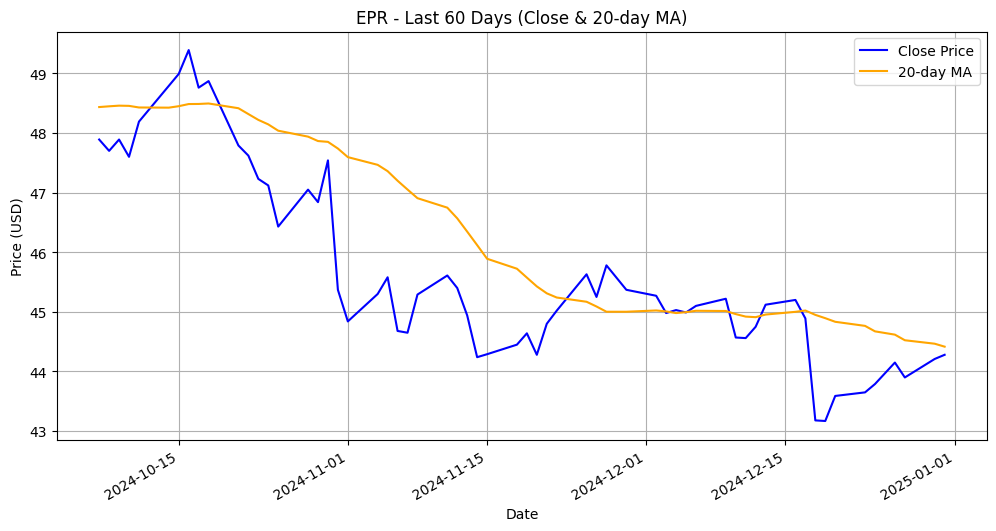


=== EPR Feature Table ===

╒═══════════════════════════╤═══════════════════════════╕
│ Feature                   │ Value                     │
╞═══════════════════════════╪═══════════════════════════╡
│ Partial Hedging Signal    │ Sideways                  │
├───────────────────────────┼───────────────────────────┤
│ Performance Attribution   │ -24.48% since 2015-01-01  │
├───────────────────────────┼───────────────────────────┤
│ Laplace’s Law Probability │ 52.94% (chance of up day) │
├───────────────────────────┼───────────────────────────┤
│ Current Close / 20-day MA │ $44.28 / $44.42           │
├───────────────────────────┼───────────────────────────┤
│ ATR (14-day)              │ $0.75 (avg daily range)   │
├───────────────────────────┼───────────────────────────┤
│ MACD / Signal             │ -0.3685 / -0.4134         │
├───────────────────────────┼───────────────────────────┤
│ Volume (30-day Avg)       │ 512734                    │
├───────────────────────────┼───────────────

In [1]:
## Analysis of EPR ##
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import requests
import datetime

##############################################
# STEP 1: DATA FETCHING FUNCTIONS
##############################################

def get_historical_data(symbol, start, end, apikey):
    """
    Fetch historical price data from FMP for a given symbol and date range.
    Returns a DataFrame with columns: open, high, low, close, volume.
    """
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start}&to={end}&apikey={apikey}"
    response = requests.get(url)
    data = response.json()

    if 'historical' in data:
        df = pd.DataFrame(data['historical'])
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        return df
    else:
        print(f"Error fetching data for {symbol}: {data}")
        return None

def get_macro_data(apikey):
    """
    Retrieve macroeconomic indicators for the current day.
    This function attempts to fetch real data from FMP.
    If unavailable, it returns simulated values.
    """
    # For demonstration, we'll attempt to use a dummy endpoint.
    # In practice, replace this with a proper API call.
    url = f"https://financialmodelingprep.com/api/v3/economic?apikey={apikey}"
    try:
        response = requests.get(url)
        data = response.json()
        # Assume data is a list of indicators and we pick the latest ones.
        if isinstance(data, list) and len(data) > 0:
            # Extract some sample indicators.
            # (The exact fields depend on the API; here we simulate.)
            interest_rate = float(data[0].get("interestRate", 2.5))
            inflation_rate = float(data[0].get("inflationRate", 2.0))
            gdp_growth = float(data[0].get("gdpGrowth", 3.0))
        else:
            # Simulated values if API doesn't return data.
            interest_rate, inflation_rate, gdp_growth = 2.5, 2.0, 3.0
    except Exception as e:
        # If the call fails, use dummy values.
        interest_rate, inflation_rate, gdp_growth = 2.5, 2.0, 3.0

    # Get today's date
    today = datetime.date.today()
    return {
        "date": today,
        "interest_rate": interest_rate,
        "inflation_rate": inflation_rate,
        "gdp_growth": gdp_growth
    }

##############################################
# STEP 2: TECHNICAL INDICATOR FUNCTIONS
##############################################

def moving_average(df, window=20):
    """Calculate the simple moving average of the 'close' column."""
    return df['close'].rolling(window=window).mean()

def ATR(df, window=14):
    """Calculate the Average True Range (ATR) for volatility."""
    df['prev_close'] = df['close'].shift(1)
    df['tr1'] = df['high'] - df['low']
    df['tr2'] = (df['high'] - df['prev_close']).abs()
    df['tr3'] = (df['low'] - df['prev_close']).abs()
    df['true_range'] = df[['tr1','tr2','tr3']].max(axis=1)
    atr = df['true_range'].rolling(window=window).mean()
    df.drop(['prev_close','tr1','tr2','tr3','true_range'], axis=1, inplace=True)
    return atr

def MACD(df):
    """Calculate the MACD and signal line."""
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    macd_line = ema12 - ema26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    return macd_line, signal_line

def bollinger_band_width(df, window=20, num_std=2):
    """Calculate the Bollinger Band Width as a percentage."""
    ma = df['close'].rolling(window=window).mean()
    std = df['close'].rolling(window=window).std()
    upper_band = ma + num_std * std
    lower_band = ma - num_std * std
    bb_width = (upper_band - lower_band) / ma
    return bb_width

def price_rate_of_change(df, period=10):
    """Calculate the Price Rate of Change (ROC) over a given period."""
    roc = ((df['close'] - df['close'].shift(period)) / df['close'].shift(period)) * 100
    return roc

def laplace_probability(win_count, total):
    """Calculate probability using Laplace's law: (w+1)/(n+2)."""
    return (win_count + 1) / (total + 2)

##############################################
# STEP 3: MAIN SCRIPT FOR EPR ANALYSIS
##############################################

# User inputs
apikey = getpass.getpass("Enter your FMP API Key Here: ")
start = '2015-01-01'
end = '2025-01-01'
symbol = 'EPR'

# Fetch EPR historical data
epr_df = get_historical_data(symbol, start, end, apikey)
if epr_df is None:
    print("Failed to fetch EPR data.")
    exit()

# Retrieve macroeconomic indicators for today
macro_data = get_macro_data(apikey)

# ------------------------------
# Feature Calculations:
# ------------------------------

# 1. Partial Hedging Signal:
#    We'll check if the market is sideways by examining the slope of a 20-day moving average.
ma20 = moving_average(epr_df, window=20)
ma_slope = ma20.diff().rolling(window=5).mean()  # Average change over 5 days
sideways = ma_slope.abs().iloc[-1] < 0.1  # Threshold for sideways movement

# Dynamic investment:
# Base long investment is $100. If ATR (relative move) is high, invest more.
atr_value = ATR(epr_df.copy(), window=14).iloc[-1]
current_close = epr_df['close'].iloc[-1]
relative_move = atr_value / current_close  # e.g., 0.05 means 5%
# Increase investment if relative_move is above 5%
if relative_move > 0.05:
    multiplier = 1 + (relative_move - 0.05) * 10  # simple scaling factor
else:
    multiplier = 1
recommended_long = 100 * multiplier
recommended_short = 0.25 * recommended_long if sideways else 0  # Hedge only in sideways markets

# 2. Performance Attribution:
overall_return = (epr_df['close'].iloc[-1] - epr_df['close'].iloc[0]) / epr_df['close'].iloc[0] * 100

# 3. Laplace’s Law Probability:
recent_close = epr_df['close'].iloc[-101:]  # Last 100 days + initial day
win_days = (recent_close.diff() > 0).sum()
laplace_prob = laplace_probability(win_days, len(recent_close) - 1)

# 4. Closing Price and Moving Average:
current_ma20 = ma20.iloc[-1]

# 5. ATR for Volatility: (already computed as atr_value)

# 6. MACD for Momentum:
macd_line, signal_line = MACD(epr_df)
current_macd = macd_line.iloc[-1]
current_signal = signal_line.iloc[-1]

# 7. Volume Analysis:
avg_volume = epr_df['volume'].rolling(window=30).mean().iloc[-1] if 'volume' in epr_df.columns else None

# 8. Macro-Economic Indicators (from get_macro_data):
interest_rate = macro_data["interest_rate"]
inflation_rate = macro_data["inflation_rate"]
gdp_growth = macro_data["gdp_growth"]

# 9. Bollinger Band Width:
bb_width = bollinger_band_width(epr_df, window=20).iloc[-1]

# 10. Price Rate of Change (ROC):
roc_value = price_rate_of_change(epr_df, period=10).iloc[-1]

##############################################
# STEP 4: PLAIN ENGLISH OUTPUT & DYNAMIC RECOMMENDATION
##############################################

print("\n=== EPR Feature Analysis and Dynamic Trade Recommendation ===\n")

# Today's Date and Macro Data
print(f"Today is: {macro_data['date']}")
print(f"Macro-Economic Indicators (as of today):")
print(f" - Interest Rate: {interest_rate}%")
print(f" - Inflation Rate: {inflation_rate}%")
print(f" - GDP Growth: {gdp_growth}%\n")

# Feature 1: Partial Hedging Signal
if sideways:
    print("Feature: Partial Hedging Signal")
    print(" - EPR appears to be in a sideways, accumulation phase based on the 20-day MA slope.")
else:
    print("Feature: Trend Signal")
    print(" - EPR is trending strongly rather than trading sideways.")

# Feature 2: Performance Attribution
print(f"\nFeature: Performance Attribution")
print(f" - Overall return since {start}: {overall_return:.2f}%")

# Feature 3: Laplace’s Probability
print(f"\nFeature: Laplace’s Law Probability")
print(f" - Based on the last 100 days, the probability of an up day is estimated at {laplace_prob*100:.2f}%")

# Feature 4: Closing Price and Moving Average
print(f"\nFeature: Price Trend")
print(f" - Current closing price: ${current_close:.2f}")
print(f" - 20-day Moving Average: ${current_ma20:.2f}")

# Feature 5: ATR for Volatility
print(f"\nFeature: ATR (Volatility)")
print(f" - ATR (14-day): ${atr_value:.2f} (indicates the average price movement range)")

# Feature 6: MACD for Momentum
print(f"\nFeature: MACD for Momentum")
print(f" - Current MACD: {current_macd:.4f} (Signal line: {current_signal:.4f})")
if current_macd > current_signal:
    print("   This suggests bullish momentum; the MACD line is above the signal line.")
else:
    print("   This suggests bearish momentum; the MACD line is below the signal line.")

# Feature 7: Volume Analysis
if avg_volume is not None:
    print(f"\nFeature: Volume Analysis")
    print(f" - 30-day Average Volume: {avg_volume:.0f} shares (higher volume can confirm trends)")
else:
    print("Volume data is not available.")

# Feature 8: Macro-Economic Indicators (already printed above)

# Feature 9: Bollinger Band Width
print(f"\nFeature: Bollinger Band Width")
print(f" - Current Bollinger Band Width: {bb_width*100:.2f}% (a wider band indicates higher volatility)")

# Feature 10: Price Rate of Change (ROC)
print(f"\nFeature: Price Rate of Change (ROC)")
print(f" - 10-day ROC: {roc_value:.2f}% (a positive ROC indicates upward momentum)")

# Dynamic Trade Recommendation:
print("\n--- Dynamic Trade Recommendation ---")
print(f"Based on today's analysis:")
if sideways:
    print(" - EPR appears to be in a sideways (accumulation) range.")
else:
    print(" - EPR shows a clear trend.")

# Adjust the investment size based on relative volatility:
print(f" - The ATR relative to the current price is {relative_move*100:.2f}%.")
if relative_move > 0.05:
    print("   This higher volatility suggests a larger price movement is possible.")
else:
    print("   Volatility is moderate; expect smaller moves.")

print(f"\nCalculated Investment Recommendations:")
print(f" - Recommended Long Position: ${recommended_long:.2f}")
if recommended_short > 0:
    print(f" - Recommended Short Offset: ${recommended_short:.2f} (to hedge risk in sideways markets)")
else:
    print(" - No short offset recommended in a strong trending market.")

# Estimate potential profit/loss (simplified based on ATR):
predicted_move = atr_value  # estimated move in dollars
potential_profit = recommended_long * (predicted_move / current_close)
potential_loss = recommended_short * (predicted_move / current_close) if recommended_short > 0 else 0

print("\nBased on historical volatility (ATR):")
print(f" - If EPR moves by approximately ${predicted_move:.2f} in the next period:")
print(f"   * Your long position could yield a profit of approximately ${potential_profit:.2f}.")
if recommended_short > 0:
    print(f"   * Your short hedge could mitigate a potential loss of around ${potential_loss:.2f}.")

!pip install tabulate
##############################################
# STEP 5: "Sexier" Output: Plot + Table
##############################################
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from tabulate import tabulate

# 1. Quick Chart of EPR’s Last 60 Days with 20-day MA
days_to_plot = 60  # Change as desired
recent_data = epr_df.tail(days_to_plot)
recent_ma20 = ma20.tail(days_to_plot)

plt.figure(figsize=(12,6))
plt.plot(recent_data.index, recent_data['close'], label="Close Price", color='blue')
plt.plot(recent_ma20.index, recent_ma20, label="20-day MA", color='orange')
plt.title(f"EPR - Last {days_to_plot} Days (Close & 20-day MA)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
# Format x-axis dates for readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Auto-rotate date labels
plt.show()

# 2. Tabulated Feature Summary
#    We'll show each feature and its latest value in a neat table.

feature_table = [
    ["Partial Hedging Signal", "Sideways" if sideways else "Trending"],
    ["Performance Attribution", f"{overall_return:.2f}% since {start}"],
    ["Laplace’s Law Probability", f"{laplace_prob*100:.2f}% (chance of up day)"],
    ["Current Close / 20-day MA", f"${current_close:.2f} / ${current_ma20:.2f}"],
    ["ATR (14-day)", f"${atr_value:.2f} (avg daily range)"],
    ["MACD / Signal", f"{current_macd:.4f} / {current_signal:.4f}"],
    ["Volume (30-day Avg)",
        f"{avg_volume:.0f}" if avg_volume is not None else "N/A"],
    ["Bollinger Band Width",
        f"{bb_width*100:.2f}% (volatility range)"],
    ["ROC (10-day)",
        f"{roc_value:.2f}% (momentum)"],
    ["Recommended Long",
        f"${recommended_long:.2f}"],
    ["Recommended Short",
        f"${recommended_short:.2f}" if recommended_short > 0 else "None"],
]

print("\n=== EPR Feature Table ===\n")
print(tabulate(feature_table, headers=["Feature", "Value"], tablefmt="fancy_grid"))
print("\nEnjoy your more stylish output!\n")


Enter your FMP API Key Here: ··········

=== EBAY Feature Analysis and Dynamic Trade Recommendation ===

Today is: 2025-03-17
Macro-Economic Indicators (as of today):
 - Interest Rate: 2.5%
 - Inflation Rate: 2.0%
 - GDP Growth: 3.0%

Feature: Partial Hedging Signal
 - EBAY appears to be in a sideways, accumulation phase based on the 20-day MA slope.

Feature: Performance Attribution
 - Overall return since 2015-01-01: 161.83%

Feature: Laplace’s Law Probability
 - Based on the last 100 days, the probability of an up day is estimated at 53.92%

Feature: Price Trend
 - Current closing price: $61.95
 - 20-day Moving Average: $63.59

Feature: ATR (Volatility)
 - ATR (14-day): $1.49 (indicates the average price movement range)

Feature: MACD for Momentum
 - Current MACD: -0.0809 (Signal line: 0.1843)
   This suggests bearish momentum; the MACD line is below the signal line.

Feature: Volume Analysis
 - 30-day Average Volume: 4071676 shares (higher volume can confirm trends)

Feature: Bolli

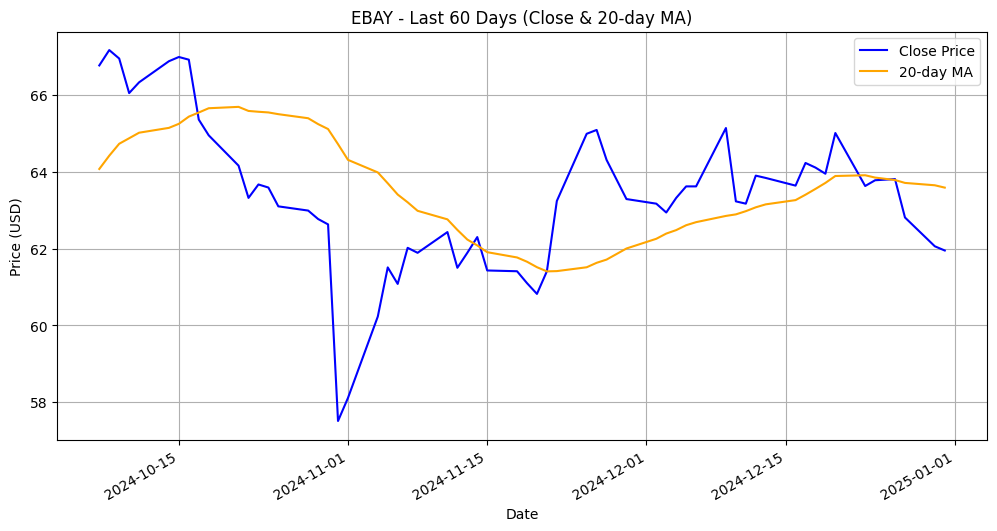


=== EBAY Feature Table ===

╒═══════════════════════════╤═══════════════════════════╕
│ Feature                   │ Value                     │
╞═══════════════════════════╪═══════════════════════════╡
│ Partial Hedging Signal    │ Sideways                  │
├───────────────────────────┼───────────────────────────┤
│ Performance Attribution   │ 161.83% since 2015-01-01  │
├───────────────────────────┼───────────────────────────┤
│ Laplace’s Law Probability │ 53.92% (chance of up day) │
├───────────────────────────┼───────────────────────────┤
│ Current Close / 20-day MA │ $61.95 / $63.59           │
├───────────────────────────┼───────────────────────────┤
│ ATR (14-day)              │ $1.49 (avg daily range)   │
├───────────────────────────┼───────────────────────────┤
│ MACD / Signal             │ -0.0809 / 0.1843          │
├───────────────────────────┼───────────────────────────┤
│ Volume (30-day Avg)       │ 4071676                   │
├───────────────────────────┼──────────────

In [2]:
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import requests
import datetime

##############################################
# STEP 1: DATA FETCHING FUNCTIONS
##############################################

def get_historical_data(symbol, start, end, apikey):
    """
    Fetch historical price data from FMP for a given symbol and date range.
    Returns a DataFrame with columns: open, high, low, close, volume.
    """
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start}&to={end}&apikey={apikey}"
    response = requests.get(url)
    data = response.json()

    if 'historical' in data:
        df = pd.DataFrame(data['historical'])
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        return df
    else:
        print(f"Error fetching data for {symbol}: {data}")
        return None

def get_macro_data(apikey):
    """
    Retrieve macroeconomic indicators for the current day.
    This function attempts to fetch real data from FMP.
    If unavailable, it returns simulated values.
    """
    url = f"https://financialmodelingprep.com/api/v3/economic?apikey={apikey}"
    try:
        response = requests.get(url)
        data = response.json()
        # Assume data is a list of indicators and we pick the latest ones.
        if isinstance(data, list) and len(data) > 0:
            interest_rate = float(data[0].get("interestRate", 2.5))
            inflation_rate = float(data[0].get("inflationRate", 2.0))
            gdp_growth = float(data[0].get("gdpGrowth", 3.0))
        else:
            # Simulated values if API doesn't return data.
            interest_rate, inflation_rate, gdp_growth = 2.5, 2.0, 3.0
    except Exception as e:
        # If the call fails, use dummy values.
        interest_rate, inflation_rate, gdp_growth = 2.5, 2.0, 3.0

    today = datetime.date.today()
    return {
        "date": today,
        "interest_rate": interest_rate,
        "inflation_rate": inflation_rate,
        "gdp_growth": gdp_growth
    }

##############################################
# STEP 2: TECHNICAL INDICATOR FUNCTIONS
##############################################

def moving_average(df, window=20):
    """Calculate the simple moving average of the 'close' column."""
    return df['close'].rolling(window=window).mean()

def ATR(df, window=14):
    """Calculate the Average True Range (ATR) for volatility."""
    df['prev_close'] = df['close'].shift(1)
    df['tr1'] = df['high'] - df['low']
    df['tr2'] = (df['high'] - df['prev_close']).abs()
    df['tr3'] = (df['low'] - df['prev_close']).abs()
    df['true_range'] = df[['tr1','tr2','tr3']].max(axis=1)
    atr = df['true_range'].rolling(window=window).mean()
    df.drop(['prev_close','tr1','tr2','tr3','true_range'], axis=1, inplace=True)
    return atr

def MACD(df):
    """Calculate the MACD and signal line."""
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    macd_line = ema12 - ema26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    return macd_line, signal_line

def bollinger_band_width(df, window=20, num_std=2):
    """Calculate the Bollinger Band Width as a percentage."""
    ma = df['close'].rolling(window=window).mean()
    std = df['close'].rolling(window=window).std()
    upper_band = ma + num_std * std
    lower_band = ma - num_std * std
    bb_width = (upper_band - lower_band) / ma
    return bb_width

def price_rate_of_change(df, period=10):
    """Calculate the Price Rate of Change (ROC) over a given period."""
    roc = ((df['close'] - df['close'].shift(period)) / df['close'].shift(period)) * 100
    return roc

def laplace_probability(win_count, total):
    """Calculate probability using Laplace's law: (w+1)/(n+2)."""
    return (win_count + 1) / (total + 2)

##############################################
# STEP 3: MAIN SCRIPT FOR EBAY ANALYSIS
##############################################

apikey = getpass.getpass("Enter your FMP API Key Here: ")
start = '2015-01-01'
end = '2025-01-01'
symbol = 'EBAY'

# Fetch EBAY historical data
ebay_df = get_historical_data(symbol, start, end, apikey)
if ebay_df is None:
    print("Failed to fetch EBAY data.")
    exit()

# Retrieve macroeconomic indicators for today
macro_data = get_macro_data(apikey)

# ------------------------------
# Feature Calculations:
# ------------------------------
ma20 = moving_average(ebay_df, window=20)
ma_slope = ma20.diff().rolling(window=5).mean()
sideways = ma_slope.abs().iloc[-1] < 0.1

atr_value = ATR(ebay_df.copy(), window=14).iloc[-1]
current_close = ebay_df['close'].iloc[-1]
relative_move = atr_value / current_close

if relative_move > 0.05:
    multiplier = 1 + (relative_move - 0.05) * 10
else:
    multiplier = 1
recommended_long = 100 * multiplier
recommended_short = 0.25 * recommended_long if sideways else 0

overall_return = (ebay_df['close'].iloc[-1] - ebay_df['close'].iloc[0]) / ebay_df['close'].iloc[0] * 100

recent_close = ebay_df['close'].iloc[-101:]
win_days = (recent_close.diff() > 0).sum()
laplace_prob = laplace_probability(win_days, len(recent_close) - 1)

current_ma20 = ma20.iloc[-1]

macd_line, signal_line = MACD(ebay_df)
current_macd = macd_line.iloc[-1]
current_signal = signal_line.iloc[-1]

avg_volume = ebay_df['volume'].rolling(window=30).mean().iloc[-1] if 'volume' in ebay_df.columns else None

interest_rate = macro_data["interest_rate"]
inflation_rate = macro_data["inflation_rate"]
gdp_growth = macro_data["gdp_growth"]

bb_width = bollinger_band_width(ebay_df, window=20).iloc[-1]
roc_value = price_rate_of_change(ebay_df, period=10).iloc[-1]

##############################################
# STEP 4: PLAIN ENGLISH OUTPUT & DYNAMIC RECOMMENDATION
##############################################

print("\n=== EBAY Feature Analysis and Dynamic Trade Recommendation ===\n")

print(f"Today is: {macro_data['date']}")
print(f"Macro-Economic Indicators (as of today):")
print(f" - Interest Rate: {interest_rate}%")
print(f" - Inflation Rate: {inflation_rate}%")
print(f" - GDP Growth: {gdp_growth}%\n")

if sideways:
    print("Feature: Partial Hedging Signal")
    print(" - EBAY appears to be in a sideways, accumulation phase based on the 20-day MA slope.")
else:
    print("Feature: Trend Signal")
    print(" - EBAY is trending strongly rather than trading sideways.")

print(f"\nFeature: Performance Attribution")
print(f" - Overall return since {start}: {overall_return:.2f}%")

print(f"\nFeature: Laplace’s Law Probability")
print(f" - Based on the last 100 days, the probability of an up day is estimated at {laplace_prob*100:.2f}%")

print(f"\nFeature: Price Trend")
print(f" - Current closing price: ${current_close:.2f}")
print(f" - 20-day Moving Average: ${current_ma20:.2f}")

print(f"\nFeature: ATR (Volatility)")
print(f" - ATR (14-day): ${atr_value:.2f} (indicates the average price movement range)")

print(f"\nFeature: MACD for Momentum")
print(f" - Current MACD: {current_macd:.4f} (Signal line: {current_signal:.4f})")
if current_macd > current_signal:
    print("   This suggests bullish momentum; the MACD line is above the signal line.")
else:
    print("   This suggests bearish momentum; the MACD line is below the signal line.")

if avg_volume is not None:
    print(f"\nFeature: Volume Analysis")
    print(f" - 30-day Average Volume: {avg_volume:.0f} shares (higher volume can confirm trends)")
else:
    print("Volume data is not available.")

print(f"\nFeature: Bollinger Band Width")
print(f" - Current Bollinger Band Width: {bb_width*100:.2f}% (a wider band indicates higher volatility)")

print(f"\nFeature: Price Rate of Change (ROC)")
print(f" - 10-day ROC: {roc_value:.2f}% (a positive ROC indicates upward momentum)")

print("\n--- Dynamic Trade Recommendation ---")
print("Based on today's analysis:")
if sideways:
    print(" - EBAY appears to be in a sideways (accumulation) range.")
else:
    print(" - EBAY shows a clear trend.")

print(f" - The ATR relative to the current price is {relative_move*100:.2f}%.")
if relative_move > 0.05:
    print("   This higher volatility suggests a larger price movement is possible.")
else:
    print("   Volatility is moderate; expect smaller moves.")

print(f"\nCalculated Investment Recommendations:")
print(f" - Recommended Long Position: ${recommended_long:.2f}")
if recommended_short > 0:
    print(f" - Recommended Short Offset: ${recommended_short:.2f} (to hedge risk in sideways markets)")
else:
    print(" - No short offset recommended in a strong trending market.")

predicted_move = atr_value
potential_profit = recommended_long * (predicted_move / current_close)
potential_loss = recommended_short * (predicted_move / current_close) if recommended_short > 0 else 0

print("\nBased on historical volatility (ATR):")
print(f" - If EBAY moves by approximately ${predicted_move:.2f} in the next period:")
print(f"   * Your long position could yield a profit of approximately ${potential_profit:.2f}.")
if recommended_short > 0:
    print(f"   * Your short hedge could mitigate a potential loss of around ${potential_loss:.2f}.")

!pip install tabulate

##############################################
# STEP 5: "Sexier" Output: Plot + Table
##############################################
import matplotlib.dates as mdates
from tabulate import tabulate

# 1. Quick Chart of EBAY’s Last 60 Days with 20-day MA
days_to_plot = 60
recent_data = ebay_df.tail(days_to_plot)
recent_ma20 = ma20.tail(days_to_plot)

plt.figure(figsize=(12,6))
plt.plot(recent_data.index, recent_data['close'], label="Close Price", color='blue')
plt.plot(recent_ma20.index, recent_ma20, label="20-day MA", color='orange')
plt.title(f"EBAY - Last {days_to_plot} Days (Close & 20-day MA)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()

# 2. Tabulated Feature Summary
feature_table = [
    ["Partial Hedging Signal", "Sideways" if sideways else "Trending"],
    ["Performance Attribution", f"{overall_return:.2f}% since {start}"],
    ["Laplace’s Law Probability", f"{laplace_prob*100:.2f}% (chance of up day)"],
    ["Current Close / 20-day MA", f"${current_close:.2f} / ${current_ma20:.2f}"],
    ["ATR (14-day)", f"${atr_value:.2f} (avg daily range)"],
    ["MACD / Signal", f"{current_macd:.4f} / {current_signal:.4f}"],
    ["Volume (30-day Avg)", f"{avg_volume:.0f}" if avg_volume is not None else "N/A"],
    ["Bollinger Band Width", f"{bb_width*100:.2f}% (volatility range)"],
    ["ROC (10-day)", f"{roc_value:.2f}% (momentum)"],
    ["Recommended Long", f"${recommended_long:.2f}"],
    ["Recommended Short", f"${recommended_short:.2f}" if recommended_short > 0 else "None"],
]

print("\n=== EBAY Feature Table ===\n")
print(tabulate(feature_table, headers=["Feature", "Value"], tablefmt="fancy_grid"))
print("\nEnjoy your more stylish output!\n")


Enter your FMP API Key Here: ··········

=== EBAY Feature Analysis and Dynamic Trade Recommendation ===

Today is: 2025-03-17
Macro-Economic Indicators (as of today):
 - Interest Rate: 2.5%
 - Inflation Rate: 2.0%
 - GDP Growth: 3.0%

Feature: Trend Signal
 - EBAY is trending strongly rather than trading sideways.

Feature: Performance Attribution
 - Overall return since 2024-09-18: 6.14%

Feature: Laplace’s Law Probability
 - Based on the last 100 days, the probability of an up day is estimated at 48.04%

Feature: Price Trend
 - Current closing price: $67.05
 - 20-day Moving Average: $67.41

Feature: ATR (Volatility)
 - ATR (14-day): $2.75 (indicates the average price movement range)

Feature: MACD for Momentum
 - Current MACD: -0.3540 (Signal line: -0.0858)
   This suggests bearish momentum; the MACD line is below the signal line.

Feature: Volume Analysis
 - 30-day Average Volume: 5206046 shares (higher volume can confirm trends)

Feature: Bollinger Band Width
 - Current Bollinger B

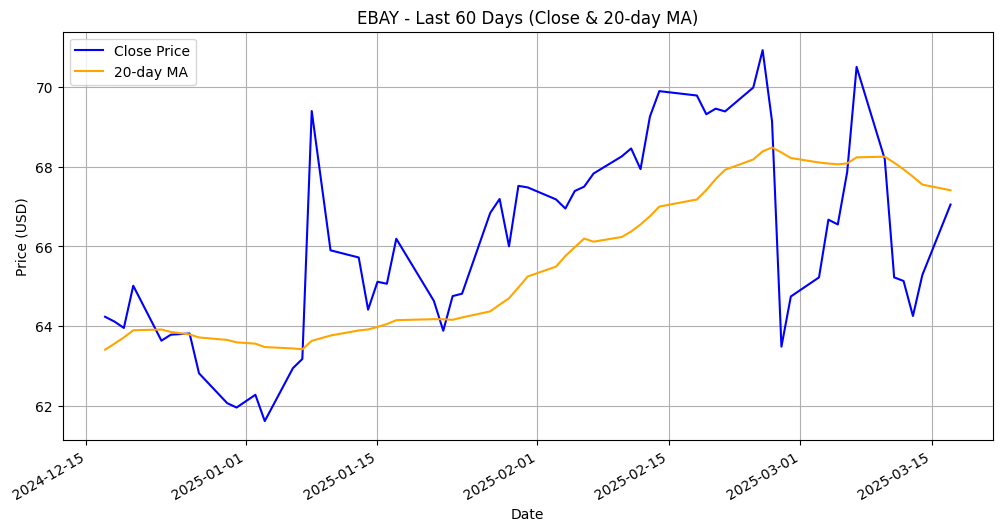


=== EBAY Feature Table ===

╒═══════════════════════════╤═══════════════════════════╕
│ Feature                   │ Value                     │
╞═══════════════════════════╪═══════════════════════════╡
│ Partial Hedging Signal    │ Trending                  │
├───────────────────────────┼───────────────────────────┤
│ Performance Attribution   │ 6.14% since 2024-09-18    │
├───────────────────────────┼───────────────────────────┤
│ Laplace’s Law Probability │ 48.04% (chance of up day) │
├───────────────────────────┼───────────────────────────┤
│ Current Close / 20-day MA │ $67.05 / $67.41           │
├───────────────────────────┼───────────────────────────┤
│ ATR (14-day)              │ $2.75 (avg daily range)   │
├───────────────────────────┼───────────────────────────┤
│ MACD / Signal             │ -0.3540 / -0.0858         │
├───────────────────────────┼───────────────────────────┤
│ Volume (30-day Avg)       │ 5206046                   │
├───────────────────────────┼──────────────

In [3]:
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import requests
import datetime

##############################################
# STEP 1: DATA FETCHING FUNCTIONS
##############################################

def get_historical_data(symbol, start, end, apikey):
    """
    Fetch historical price data from FMP for a given symbol and date range.
    Returns a DataFrame with columns: open, high, low, close, volume.
    """
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start}&to={end}&apikey={apikey}"
    response = requests.get(url)
    data = response.json()

    if 'historical' in data:
        df = pd.DataFrame(data['historical'])
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        return df
    else:
        print(f"Error fetching data for {symbol}: {data}")
        return None

def get_macro_data(apikey):
    """
    Retrieve macroeconomic indicators for the current day.
    This function attempts to fetch real data from FMP.
    If unavailable, it returns simulated values.
    """
    url = f"https://financialmodelingprep.com/api/v3/economic?apikey={apikey}"
    try:
        response = requests.get(url)
        data = response.json()
        # Assume data is a list of indicators and we pick the latest ones.
        if isinstance(data, list) and len(data) > 0:
            interest_rate = float(data[0].get("interestRate", 2.5))
            inflation_rate = float(data[0].get("inflationRate", 2.0))
            gdp_growth = float(data[0].get("gdpGrowth", 3.0))
        else:
            # Simulated values if API doesn't return data.
            interest_rate, inflation_rate, gdp_growth = 2.5, 2.0, 3.0
    except Exception:
        # If the call fails, use dummy values.
        interest_rate, inflation_rate, gdp_growth = 2.5, 2.0, 3.0

    today = datetime.date.today()
    return {
        "date": today,
        "interest_rate": interest_rate,
        "inflation_rate": inflation_rate,
        "gdp_growth": gdp_growth
    }

##############################################
# STEP 2: TECHNICAL INDICATOR FUNCTIONS
##############################################

def moving_average(df, window=20):
    """Calculate the simple moving average of the 'close' column."""
    return df['close'].rolling(window=window).mean()

def ATR(df, window=14):
    """Calculate the Average True Range (ATR) for volatility."""
    df['prev_close'] = df['close'].shift(1)
    df['tr1'] = df['high'] - df['low']
    df['tr2'] = (df['high'] - df['prev_close']).abs()
    df['tr3'] = (df['low'] - df['prev_close']).abs()
    df['true_range'] = df[['tr1','tr2','tr3']].max(axis=1)
    atr = df['true_range'].rolling(window=window).mean()
    df.drop(['prev_close','tr1','tr2','tr3','true_range'], axis=1, inplace=True)
    return atr

def MACD(df):
    """Calculate the MACD and signal line."""
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    macd_line = ema12 - ema26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    return macd_line, signal_line

def bollinger_band_width(df, window=20, num_std=2):
    """Calculate the Bollinger Band Width as a percentage."""
    ma = df['close'].rolling(window=window).mean()
    std = df['close'].rolling(window=window).std()
    upper_band = ma + num_std * std
    lower_band = ma - num_std * std
    bb_width = (upper_band - lower_band) / ma
    return bb_width

def price_rate_of_change(df, period=10):
    """Calculate the Price Rate of Change (ROC) over a given period."""
    roc = ((df['close'] - df['close'].shift(period)) / df['close'].shift(period)) * 100
    return roc

def laplace_probability(win_count, total):
    """Calculate probability using Laplace's law: (w+1)/(n+2)."""
    return (win_count + 1) / (total + 2)

##############################################
# STEP 3: MAIN SCRIPT FOR EBAY ANALYSIS
##############################################

# User inputs
apikey = getpass.getpass("Enter your FMP API Key Here: ")

# Instead of ~10 years, let's do ~6 months.
# Adjust dates as needed for your current timeframe.
# For example, from 6 months ago to today:
today = datetime.date.today()
six_months_ago = today - datetime.timedelta(days=180)

start = six_months_ago.strftime("%Y-%m-%d")  # e.g., "2024-09-19"
end = today.strftime("%Y-%m-%d")             # e.g., "2025-03-18"

symbol = 'EBAY'

# Fetch EBAY historical data
ebay_df = get_historical_data(symbol, start, end, apikey)
if ebay_df is None:
    print("Failed to fetch EBAY data.")
    exit()

# Retrieve macroeconomic indicators for today
macro_data = get_macro_data(apikey)

# ------------------------------
# Feature Calculations:
# ------------------------------
ma20 = moving_average(ebay_df, window=20)
ma_slope = ma20.diff().rolling(window=5).mean()
sideways = ma_slope.abs().iloc[-1] < 0.1

atr_value = ATR(ebay_df.copy(), window=14).iloc[-1]
current_close = ebay_df['close'].iloc[-1]
relative_move = atr_value / current_close

if relative_move > 0.05:
    multiplier = 1 + (relative_move - 0.05) * 10
else:
    multiplier = 1
recommended_long = 100 * multiplier
recommended_short = 0.25 * recommended_long if sideways else 0

overall_return = (ebay_df['close'].iloc[-1] - ebay_df['close'].iloc[0]) / ebay_df['close'].iloc[0] * 100

recent_close = ebay_df['close'].iloc[-101:]
win_days = (recent_close.diff() > 0).sum()
laplace_prob = laplace_probability(win_days, len(recent_close) - 1)

current_ma20 = ma20.iloc[-1]

macd_line, signal_line = MACD(ebay_df)
current_macd = macd_line.iloc[-1]
current_signal = signal_line.iloc[-1]

avg_volume = ebay_df['volume'].rolling(window=30).mean().iloc[-1] if 'volume' in ebay_df.columns else None

interest_rate = macro_data["interest_rate"]
inflation_rate = macro_data["inflation_rate"]
gdp_growth = macro_data["gdp_growth"]

bb_width = bollinger_band_width(ebay_df, window=20).iloc[-1]
roc_value = price_rate_of_change(ebay_df, period=10).iloc[-1]

##############################################
# STEP 4: PLAIN ENGLISH OUTPUT & DYNAMIC RECOMMENDATION
##############################################

print("\n=== EBAY Feature Analysis and Dynamic Trade Recommendation ===\n")

print(f"Today is: {macro_data['date']}")
print(f"Macro-Economic Indicators (as of today):")
print(f" - Interest Rate: {interest_rate}%")
print(f" - Inflation Rate: {inflation_rate}%")
print(f" - GDP Growth: {gdp_growth}%\n")

if sideways:
    print("Feature: Partial Hedging Signal")
    print(" - EBAY appears to be in a sideways, accumulation phase based on the 20-day MA slope.")
else:
    print("Feature: Trend Signal")
    print(" - EBAY is trending strongly rather than trading sideways.")

print(f"\nFeature: Performance Attribution")
print(f" - Overall return since {start}: {overall_return:.2f}%")

print(f"\nFeature: Laplace’s Law Probability")
print(f" - Based on the last 100 days, the probability of an up day is estimated at {laplace_prob*100:.2f}%")

print(f"\nFeature: Price Trend")
print(f" - Current closing price: ${current_close:.2f}")
print(f" - 20-day Moving Average: ${current_ma20:.2f}")

print(f"\nFeature: ATR (Volatility)")
print(f" - ATR (14-day): ${atr_value:.2f} (indicates the average price movement range)")

print(f"\nFeature: MACD for Momentum")
print(f" - Current MACD: {current_macd:.4f} (Signal line: {current_signal:.4f})")
if current_macd > current_signal:
    print("   This suggests bullish momentum; the MACD line is above the signal line.")
else:
    print("   This suggests bearish momentum; the MACD line is below the signal line.")

if avg_volume is not None:
    print(f"\nFeature: Volume Analysis")
    print(f" - 30-day Average Volume: {avg_volume:.0f} shares (higher volume can confirm trends)")
else:
    print("Volume data is not available.")

print(f"\nFeature: Bollinger Band Width")
print(f" - Current Bollinger Band Width: {bb_width*100:.2f}% (a wider band indicates higher volatility)")

print(f"\nFeature: Price Rate of Change (ROC)")
print(f" - 10-day ROC: {roc_value:.2f}% (a positive ROC indicates upward momentum)")

print("\n--- Dynamic Trade Recommendation ---")
print("Based on today's analysis:")
if sideways:
    print(" - EBAY appears to be in a sideways (accumulation) range.")
else:
    print(" - EBAY shows a clear trend.")

print(f" - The ATR relative to the current price is {relative_move*100:.2f}%.")
if relative_move > 0.05:
    print("   This higher volatility suggests a larger price movement is possible.")
else:
    print("   Volatility is moderate; expect smaller moves.")

print(f"\nCalculated Investment Recommendations:")
print(f" - Recommended Long Position: ${recommended_long:.2f}")
if recommended_short > 0:
    print(f" - Recommended Short Offset: ${recommended_short:.2f} (to hedge risk in sideways markets)")
else:
    print(" - No short offset recommended in a strong trending market.")

predicted_move = atr_value
potential_profit = recommended_long * (predicted_move / current_close)
potential_loss = recommended_short * (predicted_move / current_close) if recommended_short > 0 else 0

print("\nBased on historical volatility (ATR):")
print(f" - If EBAY moves by approximately ${predicted_move:.2f} in the next period:")
print(f"   * Your long position could yield a profit of approximately ${potential_profit:.2f}.")
if recommended_short > 0:
    print(f"   * Your short hedge could mitigate a potential loss of around ${potential_loss:.2f}.")

!pip install tabulate

##############################################
# STEP 5: "Sexier" Output: Plot + Table
##############################################
import matplotlib.dates as mdates
from tabulate import tabulate

# 1. Quick Chart of EBAY’s Last 60 Days with 20-day MA
days_to_plot = 60
recent_data = ebay_df.tail(days_to_plot)
recent_ma20 = ma20.tail(days_to_plot)

plt.figure(figsize=(12,6))
plt.plot(recent_data.index, recent_data['close'], label="Close Price", color='blue')
plt.plot(recent_ma20.index, recent_ma20, label="20-day MA", color='orange')
plt.title(f"EBAY - Last {days_to_plot} Days (Close & 20-day MA)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()

# 2. Tabulated Feature Summary
feature_table = [
    ["Partial Hedging Signal", "Sideways" if sideways else "Trending"],
    ["Performance Attribution", f"{overall_return:.2f}% since {start}"],
    ["Laplace’s Law Probability", f"{laplace_prob*100:.2f}% (chance of up day)"],
    ["Current Close / 20-day MA", f"${current_close:.2f} / ${current_ma20:.2f}"],
    ["ATR (14-day)", f"${atr_value:.2f} (avg daily range)"],
    ["MACD / Signal", f"{current_macd:.4f} / {current_signal:.4f}"],
    ["Volume (30-day Avg)", f"{avg_volume:.0f}" if avg_volume is not None else "N/A"],
    ["Bollinger Band Width", f"{bb_width*100:.2f}% (volatility range)"],
    ["ROC (10-day)", f"{roc_value:.2f}% (momentum)"],
    ["Recommended Long", f"${recommended_long:.2f}"],
    ["Recommended Short", f"${recommended_short:.2f}" if recommended_short > 0 else "None"],
]

print("\n=== EBAY Feature Table ===\n")
print(tabulate(feature_table, headers=["Feature", "Value"], tablefmt="fancy_grid"))
print("\nEnjoy your more stylish output!\n")
